# Mood/Vibe Classification for Music Recommendations

This notebook implements a deep learning classifier to categorize music tracks by mood/vibe categories (happy, sad, energetic, calm, focus). The model is trained on Spotify audio features and can be used for contextual music recommendations.

### Objective

Classify music tracks into mood/vibe categories (happy, sad, energetic, calm, focus) using Spotify audio features. This classification enables contextual music recommendations and playlist curation based on listener mood preferences.

**Key Deliverables**:
- Trained deep learning model for mood prediction
- Feature preprocessing pipeline (StandardScaler)
- Model artifacts for production deployment
- Evaluation metrics and performance analysis


In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


## 1. Setup and Imports

Import required libraries for data processing, PyTorch model training, and evaluation metrics.


In [27]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path where you saved the file in Google Drive
drive_path = '/content/drive/My Drive/Colab Notebooks/musix'


# Load the CSV file into a pandas DataFrame
spotify_df = pd.read_csv(drive_path + '/spotify.csv')

# Display the first few rows to verify
print(f"Successfully loaded 'spotify.csv' from Google Drive. Shape: {df.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded 'spotify.csv' from Google Drive. Shape: (114000, 20)


## 2. Data Loading

Load Spotify dataset from Google Drive. The dataset contains audio features for music tracks that will be used to train the mood classifier.


In [24]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path where you saved the file in Google Drive
drive_path = '/content/drive/My Drive/Colab Notebooks/musix'


# Load the CSV file into a pandas DataFrame
train_df = pd.read_csv(drive_path + '/spotify_train.csv')
test_df = pd.read_csv(drive_path + '/spotify_test.csv')
val_df = pd.read_csv(drive_path + '/spotify_val.csv')

# Display the first few rows to verify
print(f"Successfully loaded 'spotify_train.csv' from Google Drive. Shape: {train_df.shape}")
print(f"Successfully loaded 'spotify_test.csv' from Google Drive. Shape: {test_df.shape}")
print(f"Successfully loaded 'spotify_val.csv' from Google Drive. Shape: {val_df.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded 'spotify_train.csv' from Google Drive. Shape: (91200, 20)
Successfully loaded 'spotify_test.csv' from Google Drive. Shape: (11400, 20)
Successfully loaded 'spotify_val.csv' from Google Drive. Shape: (11400, 20)


In [28]:
spotify_df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [29]:
FEATURES = [
    "valence", "energy", "tempo", "acousticness", "danceability",
    "instrumentalness", "speechiness",
    "liveness", "loudness", "duration_ms", "popularity",
    "mode", "time_signature"
]

MOODS = ["happy", "sad", "energetic", "calm", "focus"]
mood2id = {m:i for i,m in enumerate(MOODS)}
id2mood = {i:m for m,i in mood2id.items()}

def assign_mood(row):
    # 1) Focus: instrumental + low speech (very strong signal)
    if (row["instrumentalness"] > 0.6) and (row["speechiness"] < 0.10):
        return "focus"

    # 2) Happy: high valence + high energy, usually major key
    if (row["valence"] > 0.70) and (row["energy"] > 0.70) and (row["mode"] == 1):
        return "happy"

    # 3) Sad: low valence, often minor key (mode=0)
    if (row["valence"] < 0.40) and (row["mode"] == 0):
        return "sad"

    # 4) Energetic: very high energy + danceable
    if (row["energy"] > 0.80) and (row["danceability"] > 0.70):
        return "energetic"

    # 5) Calm: slower tempo + acoustic
    if (row["tempo"] < 100) and (row["acousticness"] > 0.50):
        return "calm"

    # Fallbacks to avoid weird unassigned cases:
    # if it's high energy -> energetic, else calm-ish
    if row["energy"] > 0.65:
        return "energetic"
    return "calm"

# keep only needed columns and drop missing
df = spotify_df.dropna(subset=FEATURES).copy()
df.shape

(114000, 20)

## 3. Feature Definition and Mood Labeling

Define the audio features used in the model and implement mood assignment logic based on Spotify's audio feature recommendations:

- **Happy**: High valence + high energy + major key (mode=1)
- **Sad**: Low valence + minor key (mode=0)
- **Energetic**: Very high energy + high danceability
- **Calm**: Slower tempo + high acousticness
- **Focus**: High instrumentalness + low speechiness

This heuristic approach ensures meaningful mood labels based on music theory and psychoacoustics.


In [31]:
df['mood'] = df.apply(assign_mood, axis=1)
df['mood_id'] = df['mood'].map(mood2id)
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,mood,mood_id
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,calm,3
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,calm,3
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,calm,3
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,calm,3
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,calm,3


In [33]:
print(df["mood"].value_counts(normalize=True).round(3))
df[["track_name", "track_genre", "mood"]]

mood
energetic    0.335
calm         0.329
focus        0.133
sad          0.118
happy        0.085
Name: proportion, dtype: float64


,track_name,track_genre,mood
0,Comedy,acoustic,calm
1,Ghost - Acoustic,acoustic,calm
2,To Begin Again,acoustic,calm
3,Can't Help Falling In Love,acoustic,calm
4,Hold On,acoustic,calm
...,...,...,...
113995,Sleep My Little Boy,world-music,focus
113996,Water Into Light,world-music,focus
113997,Miss Perfumado,world-music,calm
113998,Friends,world-music,calm


In [35]:
X = df[FEATURES].astype(float).values
y = df["mood_id"].values

# Split dataset into train/val/test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1765, random_state=42, stratify=y_trainval
)
# 0.1765 of 0.85 ≈ 0.15 → gives 70/15/15 split

print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test: (79797, 13) (17103, 13) (17100, 13)


## 4. Data Preprocessing and Train/Val/Test Split

Prepare the data with the following steps:
1. Extract features (X) and mood labels (y)
2. Perform stratified train/val/test split (70/15/15) to ensure balanced mood distribution
3. Apply feature scaling using StandardScaler to normalize the input ranges


In [44]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("Feature scaling complete.")
display(f"X_train shape: {X_train.shape}")
display(f"X_test shape: {X_test.shape}")
display(f"X_val shape: {X_val.shape}")

Feature scaling complete.


'X_train shape: (79797, 13)'

'X_test shape: (17100, 13)'

'X_val shape: (17103, 13)'

In [46]:
class MoodDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_loader = DataLoader(MoodDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(MoodDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(MoodDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
print(f"DataLoaders created with batch size {batch_size}.")
print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

DataLoaders created with batch size 64.
Number of batches - Train: 1247, Val: 268, Test: 268


## 5. Data Loaders

Create PyTorch DataLoaders for efficient batch processing during training and evaluation.


In [53]:
class MoodNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MoodNet(input_dim=len(FEATURES), num_classes=len(MOODS)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using device: cpu


## 6. Model Architecture

Define a feedforward neural network with the following architecture:
- **Input layer**: 13 audio features
- **Hidden layer 1**: 64 units + BatchNorm + ReLU + Dropout(0.3)
- **Hidden layer 2**: 32 units + BatchNorm + ReLU + Dropout(0.2)
- **Output layer**: 5 mood classes (softmax)

The model uses:
- **Loss function**: CrossEntropyLoss
- **Optimizer**: Adam (lr=1e-3)
- **Device**: GPU (CUDA) if available, else CPU


In [60]:
def eval_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    preds_all, y_all = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            total_loss += loss.item() * len(yb)
            preds = torch.argmax(logits, dim=1)

            preds_all.append(preds.cpu().numpy())
            y_all.append(yb.cpu().numpy())

    preds_all = np.concatenate(preds_all)
    y_all = np.concatenate(y_all)

    avg_loss = total_loss / len(y_all)
    acc = accuracy_score(y_all, preds_all)
    f1m = f1_score(y_all, preds_all, average="macro")
    f1w = f1_score(y_all, preds_all, average="weighted")
    return avg_loss, acc, f1m, f1w

In [61]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0.0
    preds_all, y_all = [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(yb)
        preds = torch.argmax(logits, dim=1)

        preds_all.append(preds.detach().cpu().numpy())
        y_all.append(yb.detach().cpu().numpy())

    preds_all = np.concatenate(preds_all)
    y_all = np.concatenate(y_all)

    avg_loss = total_loss / len(y_all)
    acc = accuracy_score(y_all, preds_all)
    f1m = f1_score(y_all, preds_all, average="macro")
    f1w = f1_score(y_all, preds_all, average="weighted")
    return avg_loss, acc, f1m, f1w

## 7. Model Training

Train the model with early stopping to prevent overfitting:
- **Epochs**: Up to 50 (stops early if no improvement)
- **Patience**: 6 epochs with no improvement triggers early stopping
- **Validation metric**: Macro F1-score (balanced across mood classes)

The training loop tracks:
- Training loss, accuracy, and F1-scores
- Validation loss, accuracy, and F1-scores
- Saves best model state based on validation macro F1


In [62]:
EPOCHS = 50
patience = 6
best_val_f1 = -1
pat = 0
best_state = None

for epoch in tqdm(range(1, EPOCHS + 1)):
    tr_loss, tr_acc, tr_f1m, tr_f1w = train_epoch(model, train_loader)
    va_loss, va_acc, va_f1m, va_f1w = eval_epoch(model, val_loader)

    print(
        f"Epoch {epoch:02d} | "
        f"Train loss {tr_loss:.4f} acc {tr_acc:.3f} F1m {tr_f1m:.3f} | "
        f"Val loss {va_loss:.4f} acc {va_acc:.3f} F1m {va_f1m:.3f}"
    )

    if va_f1m > best_val_f1 + 1e-4:
        best_val_f1 = va_f1m
        pat = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        pat += 1
        if pat >= patience:
            print(f"Early stopping. Best Val Macro F1: {best_val_f1:.3f}")
            break

if best_state is not None:
    model.load_state_dict(best_state)

  2%|▏         | 1/50 [00:03<02:40,  3.27s/it]

Epoch 01 | Train loss 0.1394 acc 0.948 F1m 0.944 | Val loss 0.0743 acc 0.971 F1m 0.967


  4%|▍         | 2/50 [00:07<03:12,  4.01s/it]

Epoch 02 | Train loss 0.1272 acc 0.953 F1m 0.949 | Val loss 0.0640 acc 0.976 F1m 0.972


  6%|▌         | 3/50 [00:11<02:55,  3.73s/it]

Epoch 03 | Train loss 0.1219 acc 0.955 F1m 0.952 | Val loss 0.0625 acc 0.976 F1m 0.974


  8%|▊         | 4/50 [00:14<02:43,  3.56s/it]

Epoch 04 | Train loss 0.1125 acc 0.959 F1m 0.955 | Val loss 0.0597 acc 0.975 F1m 0.972


 10%|█         | 5/50 [00:17<02:35,  3.45s/it]

Epoch 05 | Train loss 0.1063 acc 0.961 F1m 0.958 | Val loss 0.0533 acc 0.980 F1m 0.978


 12%|█▏        | 6/50 [00:22<02:49,  3.85s/it]

Epoch 06 | Train loss 0.1037 acc 0.962 F1m 0.959 | Val loss 0.0612 acc 0.975 F1m 0.972


 14%|█▍        | 7/50 [00:25<02:37,  3.66s/it]

Epoch 07 | Train loss 0.0993 acc 0.963 F1m 0.960 | Val loss 0.0509 acc 0.980 F1m 0.978


 16%|█▌        | 8/50 [00:28<02:28,  3.54s/it]

Epoch 08 | Train loss 0.0997 acc 0.964 F1m 0.961 | Val loss 0.0558 acc 0.977 F1m 0.974


 18%|█▊        | 9/50 [00:32<02:22,  3.46s/it]

Epoch 09 | Train loss 0.0940 acc 0.966 F1m 0.963 | Val loss 0.0537 acc 0.978 F1m 0.975


 20%|██        | 10/50 [00:36<02:32,  3.82s/it]

Epoch 10 | Train loss 0.0906 acc 0.967 F1m 0.964 | Val loss 0.0476 acc 0.980 F1m 0.979


 22%|██▏       | 11/50 [00:40<02:22,  3.65s/it]

Epoch 11 | Train loss 0.0890 acc 0.967 F1m 0.965 | Val loss 0.0429 acc 0.983 F1m 0.982


 24%|██▍       | 12/50 [00:43<02:14,  3.53s/it]

Epoch 12 | Train loss 0.0852 acc 0.968 F1m 0.966 | Val loss 0.0424 acc 0.984 F1m 0.983


 26%|██▌       | 13/50 [00:46<02:09,  3.50s/it]

Epoch 13 | Train loss 0.0841 acc 0.969 F1m 0.967 | Val loss 0.0407 acc 0.984 F1m 0.984


 28%|██▊       | 14/50 [00:51<02:15,  3.77s/it]

Epoch 14 | Train loss 0.0800 acc 0.971 F1m 0.969 | Val loss 0.0408 acc 0.984 F1m 0.982


 30%|███       | 15/50 [00:54<02:07,  3.63s/it]

Epoch 15 | Train loss 0.0812 acc 0.971 F1m 0.970 | Val loss 0.0363 acc 0.987 F1m 0.986


 32%|███▏      | 16/50 [00:57<01:59,  3.52s/it]

Epoch 16 | Train loss 0.0787 acc 0.971 F1m 0.970 | Val loss 0.0373 acc 0.985 F1m 0.985


 34%|███▍      | 17/50 [01:01<01:57,  3.57s/it]

Epoch 17 | Train loss 0.0750 acc 0.972 F1m 0.971 | Val loss 0.0357 acc 0.986 F1m 0.985


 36%|███▌      | 18/50 [01:05<02:00,  3.77s/it]

Epoch 18 | Train loss 0.0730 acc 0.973 F1m 0.972 | Val loss 0.0325 acc 0.988 F1m 0.988


 38%|███▊      | 19/50 [01:08<01:52,  3.62s/it]

Epoch 19 | Train loss 0.0738 acc 0.973 F1m 0.972 | Val loss 0.0336 acc 0.986 F1m 0.985


 40%|████      | 20/50 [01:12<01:45,  3.52s/it]

Epoch 20 | Train loss 0.0743 acc 0.973 F1m 0.972 | Val loss 0.0363 acc 0.988 F1m 0.987


 42%|████▏     | 21/50 [01:15<01:44,  3.59s/it]

Epoch 21 | Train loss 0.0716 acc 0.974 F1m 0.973 | Val loss 0.0306 acc 0.989 F1m 0.988


 44%|████▍     | 22/50 [01:20<01:44,  3.75s/it]

Epoch 22 | Train loss 0.0743 acc 0.974 F1m 0.972 | Val loss 0.0308 acc 0.990 F1m 0.989


 46%|████▌     | 23/50 [01:23<01:37,  3.60s/it]

Epoch 23 | Train loss 0.0698 acc 0.975 F1m 0.974 | Val loss 0.0315 acc 0.989 F1m 0.989


 48%|████▊     | 24/50 [01:26<01:30,  3.49s/it]

Epoch 24 | Train loss 0.0711 acc 0.974 F1m 0.973 | Val loss 0.0318 acc 0.987 F1m 0.986


 50%|█████     | 25/50 [01:30<01:29,  3.59s/it]

Epoch 25 | Train loss 0.0697 acc 0.974 F1m 0.973 | Val loss 0.0324 acc 0.988 F1m 0.988


 52%|█████▏    | 26/50 [01:34<01:28,  3.69s/it]

Epoch 26 | Train loss 0.0685 acc 0.976 F1m 0.975 | Val loss 0.0319 acc 0.988 F1m 0.988


 54%|█████▍    | 27/50 [01:37<01:21,  3.56s/it]

Epoch 27 | Train loss 0.0701 acc 0.974 F1m 0.973 | Val loss 0.0347 acc 0.986 F1m 0.986


 54%|█████▍    | 27/50 [01:40<01:25,  3.74s/it]

Epoch 28 | Train loss 0.0674 acc 0.975 F1m 0.974 | Val loss 0.0351 acc 0.988 F1m 0.987
Early stopping. Best Val Macro F1: 0.989


# 8. Model Evaluation

In [68]:
# Collect all test preds
model.eval()
preds_all, y_all = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        preds_all.append(preds)
        y_all.append(yb.numpy())

y_pred = np.concatenate(preds_all)
y_true = np.concatenate(y_all)

print(classification_report(y_true, y_pred, target_names=MOODS, zero_division=0))


              precision    recall  f1-score   support

       happy       0.99      0.97      0.98      1447
         sad       0.99      0.99      0.99      2018
   energetic       0.98      0.99      0.99      5736
        calm       0.99      0.99      0.99      5619
       focus       0.99      0.99      0.99      2280

    accuracy                           0.99     17100
   macro avg       0.99      0.99      0.99     17100
weighted avg       0.99      0.99      0.99     17100



### Confusion Matrix

Visualize the confusion matrix to identify which mood categories are commonly confused by the model. This helps diagnose potential issues with specific mood classifications.


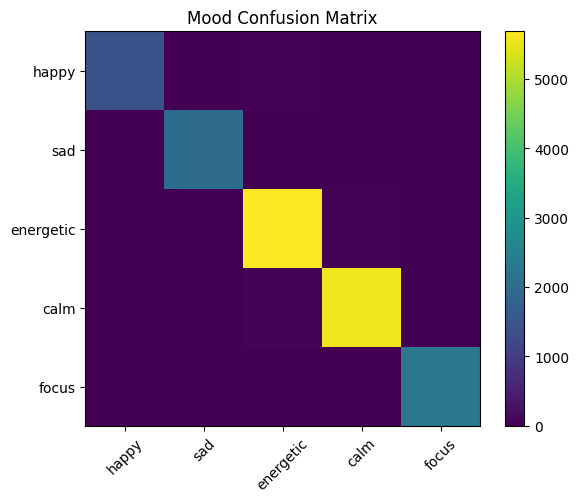

In [70]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Mood Confusion Matrix")
plt.xticks(range(len(MOODS)), MOODS, rotation=45)
plt.yticks(range(len(MOODS)), MOODS)
plt.colorbar()
plt.tight_layout()
plt.show()


## 9. Model Persistence

Save the trained model, scaler, and metadata for deployment and future use:
- **Model weights**: PyTorch state_dict for inference
- **Feature scaler**: StandardScaler for preprocessing new data
- **Mood mappings**: Encoding/decoding between mood names and indices
- **Model configuration**: Input dimensions, features, and architecture details

All artifacts are saved with timestamps for version control and easy model management.


In [ ]:
import pickle
import os
from datetime import datetime
from pathlib import Path

# Create local results directory
# Using current working directory + relative path
local_results_dir = Path.cwd() / "mood_classifier_results"
local_results_dir.mkdir(parents=True, exist_ok=True)

# Generate timestamp for model versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the trained model
model_path = local_results_dir / f"mood_classifier_{timestamp}.pt"
torch.save(model.state_dict(), str(model_path))
print(f"✓ Model saved to: {model_path}")

# Save the scaler
scaler_path = local_results_dir / f"feature_scaler_{timestamp}.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler saved to: {scaler_path}")

# Save mood mappings
mood_mappings = {
    'mood2id': mood2id,
    'id2mood': id2mood,
    'features': FEATURES,
    'moods': MOODS
}
mappings_path = local_results_dir / f"mood_mappings_{timestamp}.pkl"
with open(mappings_path, 'wb') as f:
    pickle.dump(mood_mappings, f)
print(f"✓ Mood mappings saved to: {mappings_path}")

# Save model configuration
config = {
    'input_dim': len(FEATURES),
    'num_classes': len(MOODS),
    'model_architecture': 'MoodNet',
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'features': FEATURES,
    'moods': MOODS,
    'timestamp': timestamp
}
config_path = local_results_dir / f"model_config_{timestamp}.pkl"
with open(config_path, 'wb') as f:
    pickle.dump(config, f)
print(f"✓ Model configuration saved to: {config_path}")

print(f"\n{'='*60}")
print(f"Model training and saving complete!")
print(f"{'='*60}")
print(f"Local directory: {local_results_dir.absolute()}")
print(f"Timestamp: {timestamp}")
print(f"\nSaved files:")
print(f"  - {model_path.name}")
print(f"  - {scaler_path.name}")
print(f"  - {mappings_path.name}")
print(f"  - {config_path.name}")


✓ Model saved to: mood_classifier_results/mood_classifier_20260219_062421.pt
✓ Scaler saved to: mood_classifier_results/feature_scaler_20260219_062421.pkl
✓ Mood mappings saved to: mood_classifier_results/mood_mappings_20260219_062421.pkl
✓ Model configuration saved to: mood_classifier_results/model_config_20260219_062421.pkl

Model training and saving complete!
Results directory: mood_classifier_results
Timestamp: 20260219_062421
